# Custom Yolo Object Detector

This notebook shows how to build a model to detect object using Yolov5 model.

To simplify the training and not use our computer, I used a [google colab](https://colab.research.google.com/drive/14k9hhVmwXhlVeTCJ0x2FTPjnwGerj2i1?usp=share_link)

To upload images on google colab, you have two solutions : 
- label and split them with this notebook and upload them by hand directly to google colab.
- Label them or not with this notebook and upload them on Roboflow website. There, you can label them et upload directly to google colab as shown.

In both case, [Roboflow](https://roboflow.com/) is a really good tool to find datasets already labelize.

## Virtual environnement 
Creation virtual environnement and install package to use jupyter notebook:
```console
python -m venv env
source ./env/bin/activate
python -m pip install --upgrade pip
pip install ipykernel
python -m ipykernel install --user --name=env
```

Then one the jupyter notebook select the correct kernel.

Once it is created, you should not push the virtual environment to github. With this command, you can add all files execpt some folders :
```console
git add -- . ':!path_to_folder1' ':!path_to_folder2'
```

Depending on the geometry of the objects, it can be interesting to have bounding boxes that can be rotated. For this, you can look at the github directory [yolov5_bb](https://github.com/hukaixuan19970627/yolov5_obb.git). En revanche il n'y a pas d'outils pour labeliser directement les images.

## Install Dependencies

In [ ]:
!pip install labelImg opencv-python matplotlib bing-image-downloader pyaml

In [ ]:
!pip list

## Import Packages

In [4]:
import os
import shutil
import time

import numpy as np
import random
from matplotlib import pyplot as plt
import matplotlib as mp
import yaml

import cv2

## Create Folders

In [5]:
DIR_PATH = os.getcwd()

In [12]:
paths = {
    'DATA' : os.path.join(DIR_PATH,'data'),
    'IMAGES' : os.path.join(DIR_PATH,'data','images'),
    'MODELS' : os.path.join(DIR_PATH,'data','models'),
    'SCRIPTS' : os.path.join(DIR_PATH,'scripts'),
    'TEST' : os.path.join(DIR_PATH,'data','test'),
    'TRAIN' : os.path.join(DIR_PATH,'data','train'),
    'VALID' : os.path.join(DIR_PATH,'data','valid'),
    'ZIP' : os.path.join(DIR_PATH,'data','zip'),
}

In [14]:
files = {
    'CAPTURE_PY' : os.path.join(paths['SCRIPTS'],'capture.py'),
    'CLASSES_TXT' : os.path.join(paths['DATA'],'images','classes.txt'),
    'DATASET_YAML' : os.path.join(paths['DATA'],'data.yaml'),
    'DOWNLOAD_PY' : os.path.join(paths['SCRIPTS'],'download_image.py'),
    'FILTER_PY' : os.path.join(paths['SCRIPTS'],'filter.py'),
    'QUERY_TXT' : os.path.join(paths['SCRIPTS'],'query.txt'),
}

In [18]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}
            
for folder in ['TEST','TRAIN','VALID']:
    for name in ['images','labels']:
        path = os.path.join(paths[folder],name)
        if not os.path.exists(path):
            if os.name == 'posix':
                !mkdir -p {path}
            if os.name == 'nt':
                !mkdir {path}

## Define Labels

In [6]:
labels = ['pen','pencil','scissors','eraser']

In [7]:
with open(files['CLASSES_TXT'], 'w') as f:
    for label in labels:
        f.write(label)
        f.write('\n')

In [8]:
dataset_yaml = {
    'path': paths['DATA'],
    'train': os.path.join('train', 'images'),
    'val': os.path.join('valid', 'images'),
    'test': os.path.join('test', 'images'),
    'names': dict(enumerate(labels)),
}

In [9]:
with open(files['DATASET_YAML'], 'w') as file:
    documents = yaml.dump(dataset_yaml, file)

## Capture Images

With the [capture](./scripts/capture.py) file, you can capture images. You have to precise :
- images : path to store images
- labels : path to text file containing labels
- num : number of images per label

It will display the webcam video : 
- press S to save image
- press Q to move to next label

You can also download images from google using the [download_image](./scripts/download_image.py). You have to precise :
- images : path to store images
- num : number of images per label
- query :  path to text file containing a list of query to ask google (one per line), see [query](./scripts/query.txt)

It is not really important that you images are label because they are rename at the next step with the correct label

You might have conflict with opencv at this step, in that case run the following command (in a terminal)

In [12]:
num = 2

In [13]:
# capture from webcam
command_capture = f'python {files["CAPTURE_PY"]} --images {paths["IMAGES"]} --labels {files["CLASSES_TXT"]} --num {num}'
!{command_capture}

In [ ]:
# capture from google
command_download = f'python {files["DOWNLOAD_PY"]} --images {paths["IMAGES"]} --query {files["QUERY_TXT"]} --num {num}'
!{command_download}

## Filter Data 

A PYQT5 [application](./filter.py) allows to listen to all the files saved, to decide to keep or delete it. If you keep it, you can precise :
- images : path where images are stored
- labels : path to text file containing labels

A button for each label is created, when you click on it, it rename the file with the correct label in the name (label_date.jpg)

You might have issue with opencv, in that case run the cell above  

In [31]:
!pip uninstall opencv-python --yes 
!pip install opencv-python-headless

Found existing installation: opencv-python 4.7.0.68
Uninstalling opencv-python-4.7.0.68:
  Successfully uninstalled opencv-python-4.7.0.68
  Using cached opencv_python_headless-4.7.0.68-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (49.2 MB)


In [35]:
command_app = f'python {files["FILTER_PY"]} --images {paths["IMAGES"]} --labels {files["CLASSES_TXT"]}'
print(command_app)

python /home/alessandrini/Documents/Robot/Eden_Robotics/Python/vision/detection/yolo/scripts/filter.py --images /home/alessandrini/Documents/Robot/Eden_Robotics/Python/vision/detection/yolo/data/images --labels /home/alessandrini/Documents/Robot/Eden_Robotics/Python/vision/detection/yolo/data/images/classes.txt


In [10]:
!pip uninstall opencv-python-headless --yes 
!pip install opencv-python

Found existing installation: opencv-python-headless 4.7.0.68
Uninstalling opencv-python-headless-4.7.0.68:
  Successfully uninstalled opencv-python-headless-4.7.0.68
  Using cached opencv_python-4.7.0.68-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (61.8 MB)


To the next part, run the cell above

In [36]:
def rewrite_label_id(label): 
    files = [os.path.join(paths['IMAGES'],name) for name in os.listdir(paths['IMAGES']) if label in name and name.endswith('.txt')]
    id = labels.index(label)
    for file in files: 
        if f'{label}_' in file: 
            with open(file,'r') as f:
                text = f.read()
                text = text.split('\n')
                if not text[-1]:
                    text = text[:-1]
                text = [f'{id}{line[1:]}' for line in text]
            with open(file, 'w') as f:
                for line in text:
                    f.write(line)
                    f.write('\n')

In [37]:
rewrite_label_id('eraser')

## Label images

Using the label application

In [34]:
!pip uninstall opencv-python --yes 
!pip install opencv-python-headless

Found existing installation: opencv-python 4.7.0.68
Uninstalling opencv-python-4.7.0.68:
  Successfully uninstalled opencv-python-4.7.0.68
  Using cached opencv_python_headless-4.7.0.68-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (49.2 MB)


In [ ]:
command_label = f"labelImg {paths['IMAGES']} {files['CLASSES_TXT']}"
!{command_label}

In [48]:
!pip uninstall opencv-python-headless --yes 
!pip install opencv-python

Found existing installation: opencv-python-headless 4.7.0.68
Uninstalling opencv-python-headless-4.7.0.68:
  Successfully uninstalled opencv-python-headless-4.7.0.68
  Using cached opencv_python-4.7.0.68-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (61.8 MB)


## Split Data Into Training And Testing

In [49]:
train_size = 0.8
valid_size = 0.2
test_size = 0.1

In [50]:
list_files = [os.path.splitext(file)[0] for file in os.listdir(paths['IMAGES']) if file.endswith('.txt')]
num_files = len(list_files)
test_set =  set(random.sample(list_files, int(test_size*num_files)))
substet = set(list_files) - test_set
valid_set =  set(random.sample(list(substet), int(valid_size*num_files)))
train_set = substet - valid_set

In [51]:
print(f'Training pourcentage : {len(list(train_set))/len(list_files)*100}')
print(f'Validation pourcentage : {len(list(valid_set))/len(list_files)*100}')
print(f'Test pourcentage : {len(list(test_set))/len(list_files)*100}')

Training pourcentage : 70.96774193548387
Validation pourcentage : 19.35483870967742
Test pourcentage : 9.67741935483871


In [52]:
def transfer_files(folder,files):
    for file in files : 
        if file == 'classes' :
            continue
        src_img = os.path.join(paths['IMAGES'],f'{file}.jpg')
        dst_img = os.path.join(folder,'images',f'{file}.jpg')
        shutil.move(src_img,dst_img)
        src_txt = os.path.join(paths['IMAGES'],f'{file}.txt')
        dst_txt = os.path.join(folder,'labels',f'{file}.txt')
        shutil.move(src_txt,dst_txt)

In [53]:
transfer_files(paths['TRAIN'],list(train_set))
transfer_files(paths['VALID'],list(valid_set))
transfer_files(paths['TEST'],list(test_set))

## Train, Valid And Test Repartition

If you want to see this exact repartition when you upload the images in the roboflow dataset, you need to upload the type (test,train,valid) one by one. Otherwise, you can use upload everything directly and it split them directly at that moment.

In [54]:
def color(array) : 
    data_normalizer = mp.colors.Normalize()
    color_map = mp.colors.LinearSegmentedColormap(
        "my_map",
        {
            "red": [(0, 1, 1),
                (1.0, 0.5, 0.5)],
            "green": [(0, 0.5, 0.5),
                (1.0, 0, 0)],
            "blue": [(0, 0.5, 0.5),
                (1.0, 0, 0)],
        }
    )
    return color_map(data_normalizer(array))

In [55]:
def get_labels_repartition(label_files,label_names):
    label_map = {label:i for i,label in enumerate(label_names)}
    results = {label:0 for label in label_names}
    for file in label_files:
        if 'classes' in file: 
            continue
        with open(file,'r') as f:
            text = f.read()
            text = text.split('\n')
            if not text[-1]:
                text = text[:-1]
            for line in text :
                for label in label_map:
                    if label_map[label] == int(line[0]):
                        l = label  
                        break
                results[l] += 1
    return results

def get_images_repartition(image_files,label_names):
    label_names.append('background')
    label_names.append('multiple')
    results = {label:0 for label in label_names}
    for image in image_files:
        for label in label_names:
            detect = f'{label}_'
            if detect in image :
                results[label] += 1
                break
    return results

In [56]:
test_images = [os.path.join(paths['TEST'],'images',file) for file in os.listdir(os.path.join(paths['TEST'],'images'))]
test_images_repartition = get_images_repartition(test_images,labels.copy())
test_labels = [os.path.join(paths['TEST'],'labels',file) for file in os.listdir(os.path.join(paths['TEST'],'labels'))]
test_labels_repartition = get_labels_repartition(test_labels,labels.copy())

train_images = [os.path.join(paths['TRAIN'],'images',file) for file in os.listdir(os.path.join(paths['TRAIN'],'images'))]
train_images_repartition = get_images_repartition(train_images,labels.copy())
train_labels = [os.path.join(paths['TRAIN'],'labels',file) for file in os.listdir(os.path.join(paths['TRAIN'],'labels'))]
train_labels_repartition = get_labels_repartition(train_labels,labels.copy())  

valid_images = [os.path.join(paths['VALID'],'images',file) for file in os.listdir(os.path.join(paths['VALID'],'images'))]
valid_images_repartition = get_images_repartition(valid_images,labels.copy())
valid_labels = [os.path.join(paths['VALID'],'labels',file) for file in os.listdir(os.path.join(paths['VALID'],'labels'))]
valid_labels_repartition = get_labels_repartition(valid_labels,labels.copy())

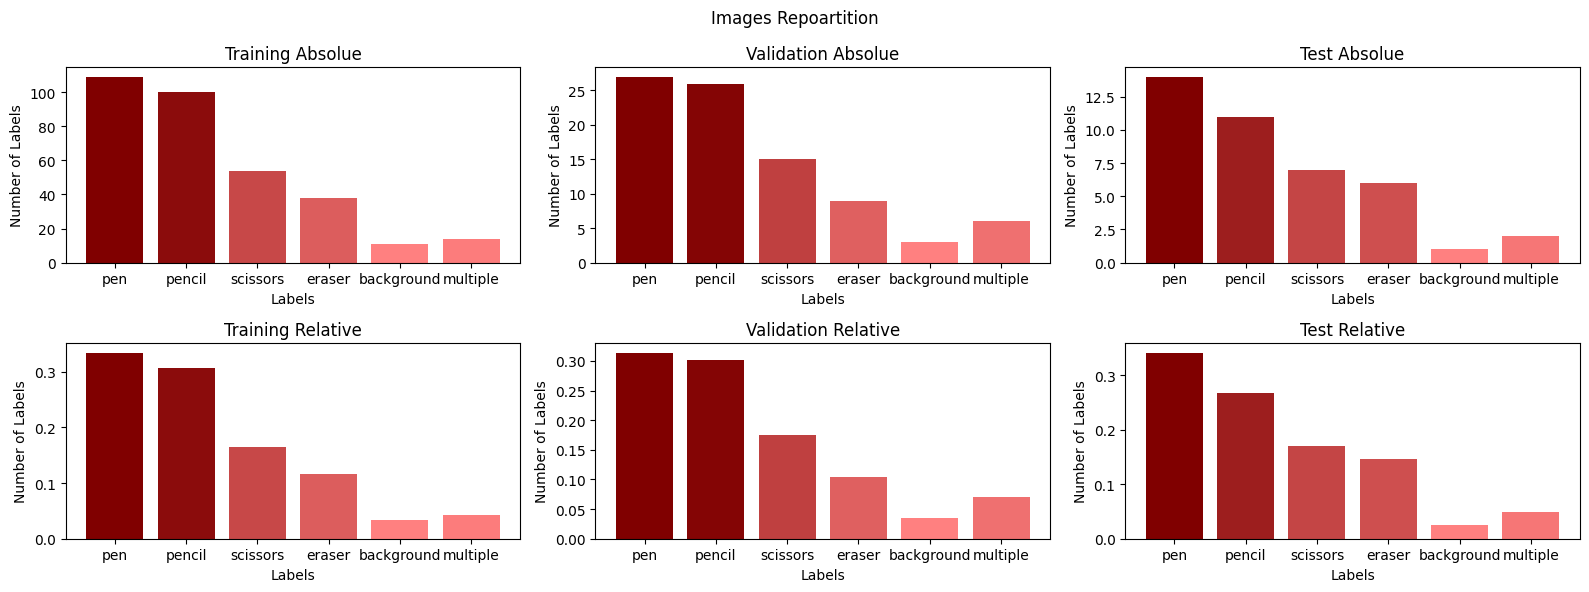

In [57]:
test_num_labels = np.array(list(test_images_repartition.values()))
train_num_labels = np.array(list(train_images_repartition.values()))
valid_num_labels = np.array(list(valid_images_repartition.values()))

fig, axes = plt.subplots(2, 3, figsize=(16, 6))

ax = axes[0][0]
ax.bar(list(train_images_repartition.keys()),train_num_labels,color=color(train_num_labels))
ax.set_xlabel('Labels')
ax.set_ylabel('Number of Labels')
ax.set_title('Training Absolue')


ax = axes[0][1]
ax.bar(list(valid_images_repartition.keys()),valid_num_labels,color=color(valid_num_labels))
ax.set_xlabel('Labels')
ax.set_ylabel('Number of Labels')
ax.set_title('Validation Absolue')

ax = axes[0][2]
ax.bar(list(test_images_repartition.keys()),test_num_labels,color=color(test_num_labels))
ax.set_xlabel('Labels')
ax.set_ylabel('Number of Labels')
ax.set_title('Test Absolue')

ax = axes[1][0]
ax.bar(list(train_images_repartition.keys()),train_num_labels/np.sum(train_num_labels),color=color(train_num_labels/np.sum(train_num_labels)))
ax.set_xlabel('Labels')
ax.set_ylabel('Number of Labels')
ax.set_title('Training Relative')

ax = axes[1][1]
ax.bar(list(valid_images_repartition.keys()),valid_num_labels/np.sum(valid_num_labels),color=color(valid_num_labels/np.sum(valid_num_labels)))
ax.set_xlabel('Labels')
ax.set_ylabel('Number of Labels')
ax.set_title('Validation Relative')

ax = axes[1][2]
ax.bar(list(test_images_repartition.keys()),test_num_labels/np.sum(test_num_labels),color=color(test_num_labels/np.sum(test_num_labels)))
ax.set_xlabel('Labels')
ax.set_ylabel('Number of Labels')
ax.set_title('Test Relative')

fig.suptitle('Images Repoartition')
fig.tight_layout()
plt.show()

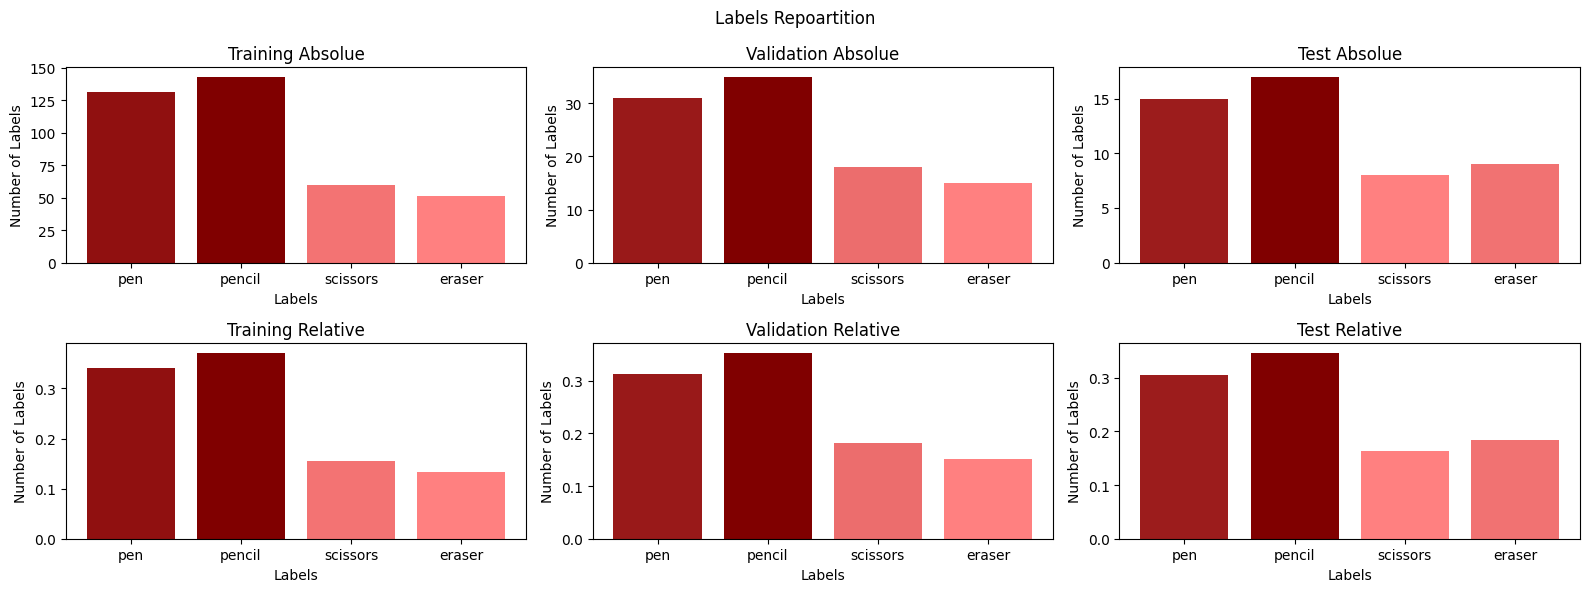

In [60]:
test_num_labels = np.array(list(test_labels_repartition.values()))
train_num_labels = np.array(list(train_labels_repartition.values()))
valid_num_labels = np.array(list(valid_labels_repartition.values()))

fig, axes = plt.subplots(2, 3, figsize=(16, 6))

ax = axes[0][0]
ax.bar(list(train_labels_repartition.keys()),train_num_labels,color=color(train_num_labels))
ax.set_xlabel('Labels')
ax.set_ylabel('Number of Labels')
ax.set_title('Training Absolue')


ax = axes[0][1]
ax.bar(list(valid_labels_repartition.keys()),valid_num_labels,color=color(valid_num_labels))
ax.set_xlabel('Labels')
ax.set_ylabel('Number of Labels')
ax.set_title('Validation Absolue')

ax = axes[0][2]
ax.bar(list(test_labels_repartition.keys()),test_num_labels,color=color(test_num_labels))
ax.set_xlabel('Labels')
ax.set_ylabel('Number of Labels')
ax.set_title('Test Absolue')

ax = axes[1][0]
ax.bar(list(train_labels_repartition.keys()),train_num_labels/np.sum(train_num_labels),color=color(train_num_labels/np.sum(train_num_labels)))
ax.set_xlabel('Labels')
ax.set_ylabel('Number of Labels')
ax.set_title('Training Relative')

ax = axes[1][1]
ax.bar(list(valid_labels_repartition.keys()),valid_num_labels/np.sum(valid_num_labels),color=color(valid_num_labels/np.sum(valid_num_labels)))
ax.set_xlabel('Labels')
ax.set_ylabel('Number of Labels')
ax.set_title('Validation Relative')

ax = axes[1][2]
ax.bar(list(test_labels_repartition.keys()),test_num_labels/np.sum(test_num_labels),color=color(test_num_labels/np.sum(test_num_labels)))
ax.set_xlabel('Labels')
ax.set_ylabel('Number of Labels')
ax.set_title('Test Relative')

fig.suptitle('Labels Repoartition')
fig.tight_layout()
plt.show()

# Zip folder

Create zip folder to upload images to google colab : 
- train 
- test
- valid

In [ ]:
for folder in ['test','train','valid']:
    zip_file = f'{folder}.zip'
    zip_folder = os.path.join(paths['ZIP'],zip_file)
    !cd {paths[f'{folder.upper()}']} && zip -r {zip_file} images labels && cp {zip_file} {zip_folder}


Create zip file to upload model weight if you want to restart training from certain point

In [21]:
model_number = 1

In [22]:
zip_file = f'model_{model_number}.zip'
weights_path = os.path.join(paths['MODELS'],f'model_{model_number}','train','weights')
zip_model = os.path.join(paths['ZIP'],zip_file)
!cd {weights_path} && zip {zip_file} best.pt && cp {zip_file} {zip_model}

updating: best.pt (deflated 10%)


You can open the folder gui to upload them

In [23]:
!nautilus {paths['ZIP']}

## Unzip Model

Once training is done and the model is downloaded, you can unzip it.

In [24]:
model_number = 2
user = 'alessandrini'

In [29]:
model_zip = os.path.join('/home',user,'Téléchargements',f'model_{model_number}.zip')
model_path = os.path.join(paths['MODELS'],f'model_{model_number}')

In [ ]:
!mkdir -p {model_path}
!unzip {model_zip} -d {model_path}
!rm {model_zip}

## See Results in tensorboard

In [31]:
!tensorboard --logdir {paths['MODELS']}

2023-01-01 20:10:54.020778: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-01 20:10:54.332936: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-01 20:10:54.387807: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/alessandrini/Documents/Robot/Eden_Robotics/Python/vision/detection/yolo/env/l

## Detection With OpenCV DNN

In [ ]:
!pip uninstall opencv-python opencv-python-headless opencv-contrib-python --yes
!pip install opencv-python opencv-contrib-python

In [62]:
img_size = 416
score_threshold = 0.2
nms_threshold = 0.4
confidence_threshold = 0.4
model_number = 0

In [63]:
model_path = os.path.join(paths['MODELS'],f'model_{model_number}','train','weights','best.onnx')

In [64]:
INPUT_WIDTH = img_size
INPUT_HEIGHT = img_size
SCORE_THRESHOLD = score_threshold
NMS_THRESHOLD = nms_threshold
CONFIDENCE_THRESHOLD = confidence_threshold

In [65]:
def build_model(model_path):
    net = cv2.dnn.readNet(model_path)
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)
    return net

In [66]:
def detect(image, net):
    blob = cv2.dnn.blobFromImage(image, 1/255.0, size = (INPUT_WIDTH, INPUT_HEIGHT), swapRB=True, crop=False)
    net.setInput(blob)
    return net.forward()

In [67]:
def wrap_detection(input_image, output_data):
    class_ids = []
    confidences = []
    boxes = []

    rows = output_data.shape[0]

    image_width, image_height, _ = input_image.shape

    x_factor = image_width / INPUT_WIDTH
    y_factor =  image_height / INPUT_HEIGHT

    for r in range(rows):
        row = output_data[r]
        confidence = row[4]
        if confidence >= 0.4:

            classes_scores = row[5:]
            _, _, _, max_indx = cv2.minMaxLoc(classes_scores)
            class_id = max_indx[1]
            if (classes_scores[class_id] > .25):

                confidences.append(confidence)

                class_ids.append(class_id)

                x, y, w, h = row[0].item(), row[1].item(), row[2].item(), row[3].item() 
                left = int((x - 0.5 * w) * x_factor)
                top = int((y - 0.5 * h) * y_factor)
                width = int(w * x_factor)
                height = int(h * y_factor)
                box = np.array([left, top, width, height])
                boxes.append(box)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.25, 0.45) 

    result_class_ids = []
    result_confidences = []
    result_boxes = []

    for i in indexes:
        result_confidences.append(confidences[i])
        result_class_ids.append(class_ids[i])
        result_boxes.append(boxes[i])

    return result_class_ids, result_confidences, result_boxes

In [68]:
def format_yolov5(frame):
    row, col, _ = frame.shape
    _max = max(col, row)
    result = np.zeros((_max, _max, 3), np.uint8)
    result[0:row, 0:col] = frame
    return result

In [ ]:
cap = cv2.VideoCapture(0)
net = build_model(model_path)

prev_frame_time = 0
new_frame_time = 0

colors = (random.randint(0, 255), random.randint(0,255), random.randint(0, 255))

while cap.isOpened():
    ret, frame = cap.read()
    frame = cv2.resize(frame,(img_size,img_size))
    # Make detections 
    inputImage = format_yolov5(frame)
    outs = detect(inputImage, net)
    class_ids, confidences, boxes = wrap_detection(inputImage, outs[0])


    for (classid, confidence, box) in zip(class_ids, confidences, boxes):
         color = colors[int(classid) % len(colors)]
         cv2.rectangle(frame, box, color, 2)
         cv2.rectangle(frame, (box[0], box[1] - 20), (box[0] + box[2], box[1]), color, -1)
         cv2.putText(frame, labels[classid], (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,0,0))

    new_frame_time = time.time()
    fps = round(1/(new_frame_time-prev_frame_time),2)
    prev_frame_time = new_frame_time
    cv2.putText(frame, f'FPS : {fps}Hz', (2, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (100, 255, 0), 1, cv2.LINE_AA)
    cv2.imshow('YOLO', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()